<center>
<h1 style="font-weight:bold;color:#a64d79">Student mental health : </br>Stress, factors and coping strategies</h1>
<p>Hadoop Project | Group 11 - 3IABD2</p>
</center>

<h2 style="font-weight:bold;color:#c27ba0">Objectives</h2>

<p>This project aims to identify the causes of stress and coping strategies through the analysis of large-scale data, using Big Data tools and machine learning techniques.</p>

<hr style="border: none; height: 0.5px; background-color: #aaa;" />

In [166]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev, min, max, col, when, count
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt
import seaborn as sns

<h2 style="font-weight:bold;color:#c27ba0">Dataframe creation</h2>

In [107]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SMHAnalysis") \
    .getOrCreate()

In [142]:
# Read CSV files from HDFS and create DataFrames
df_sample = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .csv("hdfs://localhost:9000/data_input/dataset-1.csv")

df_esgi = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .csv("hdfs://localhost:9000/data_input/dataset-2.csv")

# Cleaning column names
df_sample = df_sample.toDF(*[c.strip() for c in df_sample.columns])
df_esgi = df_esgi.toDF(*[c.strip() for c in df_esgi.columns])


df_all = df_sample.unionByName(df_esgi)

# Display the first 5 rows of sample dataset
print("------------------------------------------------------------------------")
print("Preview of the first few rows :")
print("------------------------------------------------------------------------\n")
df_all.show(5)

------------------------------------------------------------------------
Preview of the first few rows :
------------------------------------------------------------------------

+-----------+---+------+--------------------------+--------------------+----------------------------------+--------------------------------+----------------------------------+--------------+----------------+-------------+-------------------+-------------------+---------------------+------------+------------------------+---------------------+----------------------------+-----------------+-------------+
| Student ID|Age|Gender|Academic Performance (GPA)|Study Hours Per Week|Social Media Usage (Hours per day)|Sleep Duration (Hours per night)|Physical Exercise (Hours per week)|Family Support|Financial Stress|Peer Pressure|Relationship Stress|Mental Stress Level|Counseling Attendance|Diet Quality|Stress Coping Mechanisms|Cognitive Distortions|Family Mental Health History|Medical Condition|Substance Use|
+----------

<h2 style="font-weight:bold;color:#c27ba0">Preprocessing and Exploratory Data Analysis</h2>

In [109]:
# Dimensions of the dataset
print("------------------------------------------------------------------------")
print("Dimensions of dataframes :")
print("------------------------------------------------------------------------\n")

print("Rows :")
print(f"- Sample dataset : {df_sample.count()} rows")
print(f"- ESGI dataset : {df_esgi.count()} rows")
print(f"- TOTAL ROWS : {df_all.count()} rows")

print(f"\nColumns : ")
print(f"- TOTAL COLUMNS : {len(df_all.columns)} columns")

------------------------------------------------------------------------
Dimensions of dataframes :
------------------------------------------------------------------------

Rows :
- Sample dataset : 760 rows
- ESGI dataset : 174 rows
- TOTAL ROWS : 934 rows

Columns : 
- TOTAL COLUMNS : 20 columns


In [ ]:
# Columns details
print("-----------------------------------------------------------------------------------")
print("Columns details :")
print("-----------------------------------------------------------------------------------\n")

print(f"{'NAME':<40} {'TYPE':<10} {'NULL VALUES':<15} {'NON-NULL VALUES':<10}")

for column, dtype in df_all.dtypes:
    null_values = df_all.filter(col(column).isNull()).count()
    non_null_values = df_all.filter(col(column).isNotNull()).count()
    print(f"{column:<40} {dtype:15} {null_values:<15} {non_null_values:<10}")

-----------------------------------------------------------------------------------
Columns details :
-----------------------------------------------------------------------------------

NAME                                     TYPE       NULL VALUES     NON-NULL VALUES
Age                                      int             0               934       
Gender                                   int             0               934       
Academic Performance (GPA)               int             0               934       
Study Hours Per Week                     int             0               934       
Social Media Usage (Hours per day)       int             0               934       
Sleep Duration (Hours per night)         int             0               934       
Physical Exercise (Hours per week)       int             0               934       
Family Support                           int             0               934       
Financial Stress                         int             

In [143]:
# Delete Student ID column
df_sample = df_sample.drop("Student Id")
df_esgi = df_esgi.drop("Student Id")
df_all = df_all.drop("Student Id")

In [144]:
# Converting string columns to numeric types : column with YES/NO values
def yes_no_to_int(df, columns):
    for column in columns:
        if type(df.schema[column].dataType) != IntegerType:
            df = df.withColumn(
                column,
                when(col(column) == "Yes", 1)
                .when(col(column) == "No", 0)
                .cast(IntegerType())
            )
    return df

# Counselling, Family Mental Health History, Mental Condition | YES(1), NO(0)
string_columns = ["Counseling Attendance", "Family Mental Health History", "Medical Condition"]
df_sample = yes_no_to_int(df_sample, string_columns)
df_esgi = yes_no_to_int(df_esgi, string_columns)
df_all = yes_no_to_int(df_all, string_columns)

In [161]:
# Converting string columns to numeric types : columns with other values
def other_value_to_int(df, columns):
    for column in columns:
        if type(df.schema[column].dataType) != IntegerType:
            if column == "Gender":
                df = df.withColumn(
                    column,
                    when(col(column) == "Male", 1)
                    .when(col(column) == "Female", 0)
                    .otherwise(2)
                    .cast(IntegerType())
                )

            if column == "Stress Coping Mechanisms":
                coping_values = [row[0] for row in df.select("Stress Coping Mechanisms").distinct().collect()]
                coping_dict = {mechanism: i for i, mechanism in enumerate(coping_values)}
                
                expr = None
                for mechanism, value in coping_dict.items():
                    expr = when(col(column) == mechanism, value)if expr is None else expr.when(col(column) == mechanism, value)
                expr = expr.cast(IntegerType())
                df = df.withColumn(column, expr)

    return df

# Gender | MALE(0), FEMALE(1), OTHER(2)
# Stress Coping Mechanisms | SPENDING TIME ALONE(0), ...

string_columns = ["Gender", "Stress Coping Mechanisms"]

df_sample = other_value_to_int(df_sample, string_columns)
df_esgi = other_value_to_int(df_esgi, string_columns)
df_all = other_value_to_int(df_all, string_columns)

-----------------------------------------------------------------------------------
Mental Stress Level :
-----------------------------------------------------------------------------------



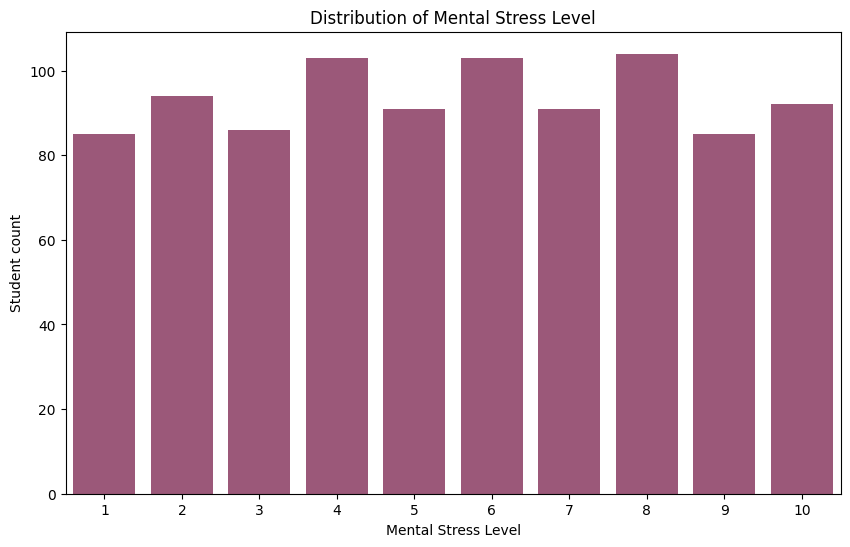

In [ ]:
# Mental Stress Level details
print("-----------------------------------------------------------------------------------")
print("Mental Stress Level :")
print("-----------------------------------------------------------------------------------\n")


# Distribution of Mental Stress Level
stress_level_distrib = df_all.groupBy("Mental Stress Level").count().sort("Mental Stress Level").collect()

levels = [row["Mental Stress Level"] for row in stress_level_distrib]
counts = [row["count"] for row in stress_level_distrib]

plt.figure(figsize=(10,6))
sns.barplot(x=levels, y=counts, color="#a64d79")
plt.xlabel("Mental Stress Level")
plt.ylabel("Student count")
plt.title("Distribution of Mental Stress Level")
plt.show()

-----------------------------------------------------------------------------------
Gender :
-----------------------------------------------------------------------------------



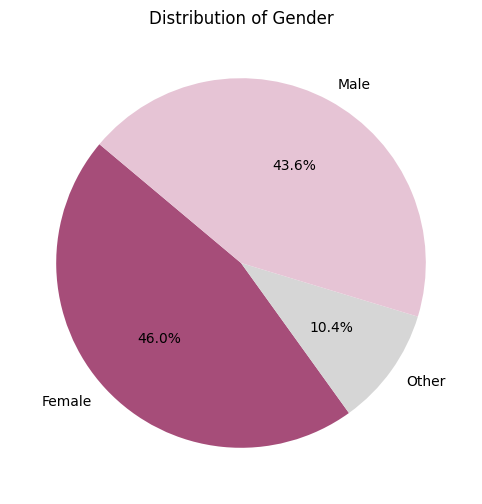

In [201]:
# Distribution of Gender

print("-----------------------------------------------------------------------------------")
print("Gender :")
print("-----------------------------------------------------------------------------------\n")


# Distribution of Gender
gender_distrib = df_all.groupBy("Gender").count().collect()
    
genders = [row["Gender"] for row in gender_distrib]
labels = ["Male" if gender == 0 else "Female" if gender == 1 else "Other" for gender in genders]
counts = [row["count"] for row in gender_distrib]

plt.figure(figsize=(10,6))
plt.pie(
    counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=["#a64d79", "#d6d6d6", "#e6c4d5"]
)
plt.title("Distribution of Gender")
plt.show()


In [ ]:

df_all.select(
    avg("Mental Stress Level").alias("Moyenne Stress"),
    stddev("Mental Stress Level").alias("Écart-type Stress"),
    min("Mental Stress Level").alias("Min Stress"),
    max("Mental Stress Level").alias("Max Stress"),
    avg("Sleep Duration (Hours per night)").alias("Moyenne Sommeil"),
    avg("Social Media Usage (Hours per day)").alias("Moyenne Réseaux"),
    avg("Academic Performance (GPA)").alias("Moyenne GPA")
).show()

df_all.groupBy("Gender").count().show()
print("Corrélation Stress ↔ Sommeil :", df_all.stat.corr("Mental Stress Level", "Sleep Duration (Hours per night)"))
print("Corrélation Stress ↔ Réseaux Sociaux :", df_all.stat.corr("Mental Stress Level", "Social Media Usage (Hours per day)"))
print("Corrélation GPA ↔ Sommeil :", df_all.stat.corr("Academic Performance (GPA)", "Sleep Duration (Hours per night)"))
df_all.groupBy("Gender").agg(avg("Mental Stress Level").alias("Stress moyen")).show()

+-----------------+------------------+----------+----------+-----------------+------------------+-----------------+
|   Moyenne Stress| Écart-type Stress|Min Stress|Max Stress|  Moyenne Sommeil|   Moyenne Réseaux|      Moyenne GPA|
+-----------------+------------------+----------+----------+-----------------+------------------+-----------------+
|5.535331905781584|2.8254573176226927|         1|        10|8.028907922912206|4.1713062098501075|2.032119914346895|
+-----------------+------------------+----------+----------+-----------------+------------------+-----------------+

+-----------+-----+
|     Gender|count|
+-----------+-----+
|Genderqueer|    7|
|    Agender|   14|
|     Female|  407|
| Polygender|   12|
|   Bigender|   16|
| Non-binary|   10|
|       Male|  430|
|Genderfluid|   12|
|      Autre|   26|
+-----------+-----+

Corrélation Stress ↔ Sommeil : 0.029504724894151107
Corrélation Stress ↔ Réseaux Sociaux : 0.01628495726134644
Corrélation GPA ↔ Sommeil : -0.0116906639137663

In [ ]:
pdf = df.toPandas()


In [ ]:
print("Statistiques descriptives des variables numériques")
print(pdf.describe())

In [ ]:
print("Valeurs uniques par colonne catégorielle")
cat_cols = pdf.select_dtypes(include="object").columns

for col in cat_cols:
    print(f"- {col} ({pdf[col].nunique()} valeurs uniques) : {pdf[col].unique()[:5]}")

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pdf, x="Family Support", y="Mental Stress Level", color="mediumseagreen")
sns.regplot(data=pdf, x="Family Support", y="Mental Stress Level", scatter=False, color="darkgreen")
plt.title("Soutien familial vs Stress mental")
plt.xlabel("Soutien familial (1 = faible, 5 = fort)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Family Support"].corr(pdf["Mental Stress Level"])
print(f"Corrélation entre le soutien familial et le stress : {correlation:.2f}")

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    scatter=False,
    color="darkgreen"
)
plt.title("Sommeil vs Performance académique (GPA)")
plt.xlabel("Durée de sommeil (heures/nuit)")
plt.ylabel("GPA (Performance académique)")
plt.tight_layout()
plt.show()

correlation = pdf["Sleep Duration (Hours per night)"].corr(pdf["Academic Performance (GPA)"])
print(f"Corrélation Sommeil ↔ GPA : {correlation:.2f}")

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Physical Exercise (Hours per week)",
    y="Mental Stress Level",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Physical Exercise (Hours per week)",
    y="Mental Stress Level",
    scatter=False,
    color="darkgreen"
)
plt.title("Activité physique vs Stress mental")
plt.xlabel("Activité physique (heures/semaine)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Physical Exercise (Hours per week)"].corr(pdf["Mental Stress Level"])
print(f"Corrélation Activité physique ↔ Stress mental : {correlation:.2f}")


In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Social Media Usage (Hours per day)",
    y="Mental Stress Level",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Social Media Usage (Hours per day)",
    y="Mental Stress Level",
    scatter=False,
    color="darkgreen"
)
plt.title("Temps passé sur les réseaux sociaux vs Stress mental")
plt.xlabel("Usage des réseaux (heures/jour)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Social Media Usage (Hours per day)"].corr(pdf["Mental Stress Level"])
print(f"Corrélation Réseaux Sociaux ↔ Stress mental : {correlation:.2f}")

In [ ]:
correlation_matrix = pdf.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation entre variables")
plt.tight_layout()
plt.show()

In [ ]:
cor_stress = correlation_matrix["Mental Stress Level"].drop("Mental Stress Level")

plt.figure(figsize=(8, 5))
cor_stress.sort_values().plot(kind='barh', color='mediumseagreen')
plt.title("Corrélation avec le stress mental")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()

In [ ]:
coping_table = pd.crosstab(pdf["Stress Coping Mechanisms"], pdf["Gender"])
print(coping_table)

strategies = coping_table.index.tolist()
x = np.arange(len(strategies))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, coping_table["Female"], width, label='Femmes', color='mediumseagreen')
plt.bar(x + width/2, coping_table["Male"], width, label='Hommes', color='darkgreen')

plt.xticks(x, strategies, rotation=45, ha='right')
plt.title("Stratégies de coping par genre")
plt.xlabel("Stratégie de coping")
plt.ylabel("Nombre de participants")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
correlation = pdf["Sleep Duration (Hours per night)"].corr(pdf["Academic Performance (GPA)"])
print(f"Corrélation Sommeil ↔ GPA : {correlation:.2f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    scatter=False,
    color="darkgreen"
)
plt.title("Sommeil vs Performance académique (GPA)")
plt.xlabel("Durée de sommeil (heures/nuit)")
plt.ylabel("GPA (Performance académique)")
plt.tight_layout()
plt.show()